<a href="https://colab.research.google.com/github/MohammadsaeedHaghi/policy-selection-under-unobsorved-confounding/blob/main/synthetic_data_for_PSUUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating Synthetic Data**

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import expit

In [ ]:
def generate_synthetic_data(n=100, gamma=1.0, lambda_0=0.0, lambda_1=1.0, seed=42):
    X = np.random.randn(n)

    S = np.random.binomial(1, 0.5, size=n)

    #Y^0
    #P(Y^0=-1) = min( 1/(1+exp(-x)) + lambda_s, 1 ).
    lambda_vals = np.where(S==1, lambda_1, lambda_0)
    p0_raw = expit(X) + lambda_vals  # 1/(1+exp(-x)) + lambda_s
    p0 = np.clip(p0_raw, 0, 1)       # enforce it is in [0,1]


    Y0 = np.where(np.random.rand(n) < p0, -1, +1)

    p1 = expit(X - 1)
    Y1 = np.where(np.random.rand(n) < p1, -1, +1)

    # \pi^0(x,y) = 1 - logistic(x + gamma * y0).
    pi0 = 1 - expit(X + gamma * Y0)
    pi1 = 1 - pi0
    T = np.where(np.random.rand(n) < pi0, 0, 1)

    # w_hat
    w_hat = np.where(T == 0, 1 / np.clip(pi0, 0, 1), 1 / np.clip(pi1, 0, 1))

    return X, S, T, Y0, Y1, w_hat


In [ ]:
if __name__ == "__main__":
    X, S, T, Y0, Y1, w_hat = generate_synthetic_data(
        n=20,
        gamma=1.0,
        lambda_0=0.0,
        lambda_1=1.0,
    )


    data_full = pd.DataFrame({
        "X": X,
        "S": S,
        "T": T,
        "Y0": Y0,
        "Y1": Y1,
        "w_hat": w_hat
    })

    print("Full Data:")
    print(data_full.head())

    #Y = Y0 if T=0, Y = Y1 if T=1
    data_observed = pd.DataFrame({
        "X": data_full["X"],
        "S": data_full["S"],
        "T": data_full["T"],
        "Y": data_full["Y0"].where(data_full["T"] == 0, data_full["Y1"]),
        "w_hat": data_full["w_hat"]

    })

    print("Observed Dta:")
    print(data_observed.head())


Full Data:
          X  S  T  Y0  Y1     w_hat
0  0.271604  0  1   1  -1  1.280381
1 -1.071273  0  0   1   1  1.931207
2 -1.867402  1  0  -1   1  1.056846
3  0.709252  0  1  -1  -1  2.337427
4  1.302669  0  1  -1   1  1.738844
Observed Dta:
          X  S  T  Y     w_hat
0  0.271604  0  1 -1  1.280381
1 -1.071273  0  0  1  1.931207
2 -1.867402  1  0 -1  1.056846
3  0.709252  0  1 -1  2.337427
4  1.302669  0  1  1  1.738844


# **Gurobi**

In [ ]:
!pip install gurobipy>=10  # install gurobipy, if not already installed
import gurobipy as gp  # import the installed package

# Create an environment with your WLS license
params = {
"WLSACCESSID": 'f1dbe423-12fa-4b68-bb3a-f0a11225f7e2',
"WLSSECRET": '716de204-5518-47b0-b152-bd515ba4637f',
"LICENSEID": 2613177,
}
env = gp.Env(params=params)

# Create the model within the Gurobi environment
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2613177
Academic license 2613177 - for non-commercial use only - registered to ha___@usc.edu


**Inner Problem**

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd

# Logistic function used for probability calculations
def logistic(z):
    """Helper logistic function."""
    return 1.0 / (1.0 + np.exp(-z))

# Main function to solve the Linear Program (LP)
def solve_my_lp(df_observed, policy, hat_w, epsilon_0=0.1, epsilon_1=0.1, Gamma=2.0):


    # Initialize Gurobi model
    m = gp.Model("MyLP")
    m.setParam("OutputFlag", 0)  # Suppress solver output

    # Extract data from DataFrame
    X_vals = df_observed["X"].values
    T_vals = df_observed["T"].values
    Y_vals = df_observed["Y"].values
    n = len(df_observed)

    # Index sets
    I = range(n)
    I0 = [i for i in I if T_vals[i] == 0]  # Control group
    I1 = [i for i in I if T_vals[i] == 1]  # Treatment group
    #print(len(I0))
    #print(len(I1))


    # Distance function for constraints
    def d(i, j):
        return (X_vals[i] - X_vals[j]) ** 2

    eps = {0: epsilon_0, 1: epsilon_1}  # Epsilon values for constraints

    # Decision variables: w_i >= 0
    w_vars = m.addVars(n, lb=0, name="w")

    # Decision variables: zeta_{ij}^t >= 0
    zeta_vars = {}
    for t in [0, 1]:
        for i_ in I:
            for j_ in I:
                if (t == 0 and j_ in I0) or (t == 1 and j_ in I1):
                    zeta_vars[(t, i_, j_)] = m.addVar(lb=0.0, name=f"zeta_{t}_{i_}_{j_}")

    # Objective function
    obj_expr = gp.LinExpr()
    for i_ in I0:
        obj_expr.addTerms(policy[0,i_] * Y_vals[i_], w_vars[i_])
    for i_ in I1:
        obj_expr.addTerms(policy[1,i_] * Y_vals[i_], w_vars[i_])
    obj_expr = (1.0 / n) * obj_expr
    m.setObjective(obj_expr, GRB.MINIMIZE)


    # Distance constraints
    for t in [0, 1]:
        for j_ in I:
            if (t == 0 and j_ in I0) or (t == 1 and j_ in I1):
                m.addConstr(
                    gp.quicksum(d(i_, j_) * zeta_vars[(t, i_, j_)] for i_ in I) <= eps[t],
                    name=f"d_constraint_t{t}_j{j_}"
                )

    # Constraints for zeta sums
    for t in [0, 1]:
        for i_ in I:
            m.addConstr(
                gp.quicksum(zeta_vars[(t, i_, j_)] for j_ in (I0 if t == 0 else I1)) == 1.0 / n,
                name=f"zeta_sum_t{t}_i{i_}"
            )

    # Linking constraints between w and zeta
    for t in [0, 1]:
        for j_ in (I0 if t == 0 else I1):
          m.addConstr(
                w_vars[j_]/n == gp.quicksum(zeta_vars[(t, i_, j_)] for i_ in I),
                name=f"w_link_{t}_j{j_}"
          )

    # Gamma-based constraints
    for i_ in I:
        m.addConstr(w_vars[i_] >= 1.0 + (1.0 / Gamma) * (hat_w[i_] - 1.0), name=f"Gamma_lower_{i_}")
        m.addConstr(w_vars[i_] <= 1.0 + Gamma * (hat_w[i_] - 1.0), name=f"Gamma_upper_{i_}")

    # Optimize the model
    m.optimize()



    # Retrieve results if the solution is optimal
    if m.status == GRB.OPTIMAL:
        obj_val = m.objVal
        #print(f"Optimal objective value = {obj_val:.4f}")

        # Retrieve w variables
        w_sol = np.array([w_vars[i_].X for i_ in I])
        print("Optimal w:", w_sol)

        # Retrieve zeta variables
        zeta_sol = {}
        for t in [0, 1]:
            for i_ in I:
                for j_ in I:
                    if (t == 0 and j_ in I0) or (t == 1 and j_ in I1):
                        zeta_sol[(t, i_, j_)] = zeta_vars[(t, i_, j_)].X

        return {
            "objective_value": obj_val,
            "w": w_sol,
            "zeta": zeta_sol
        }
    else:
        print(f"Model ended with non-OPTIMAL status: {m.status}")
        return None



Solving for Gamma = 1
Model ended with non-OPTIMAL status: 4
Solution for Gamma 1: None

Solving for Gamma = 2
Model ended with non-OPTIMAL status: 4
Solution for Gamma 2: None

Solving for Gamma = 3
Optimal w: [1.8411444  1.31040247 1.17053923 5.01228177 3.21653098 2.66607447
 1.63190003 1.08541854 2.97635026 1.0973368  1.26807642 1.27149384
 1.69093468 2.         1.11846755 4.9536926  2.05105492 1.02826244
 1.25894868 1.35108993]
Solution for Gamma 3: {'objective_value': -0.37273458435803886, 'w': array([1.8411444 , 1.31040247, 1.17053923, 5.01228177, 3.21653098,
       2.66607447, 1.63190003, 1.08541854, 2.97635026, 1.0973368 ,
       1.26807642, 1.27149384, 1.69093468, 2.        , 1.11846755,
       4.9536926 , 2.05105492, 1.02826244, 1.25894868, 1.35108993]), 'zeta': {(0, 0, 1): 0.05, (0, 0, 2): 0.0, (0, 0, 5): 0.0, (0, 0, 6): 0.0, (0, 0, 7): 0.0, (0, 0, 9): 0.0, (0, 0, 10): 0.0, (0, 0, 11): 0.0, (0, 0, 12): 0.0, (0, 0, 14): 0.0, (0, 0, 16): 0.0, (0, 0, 17): 0.0, (0, 0, 18): 0.0, 

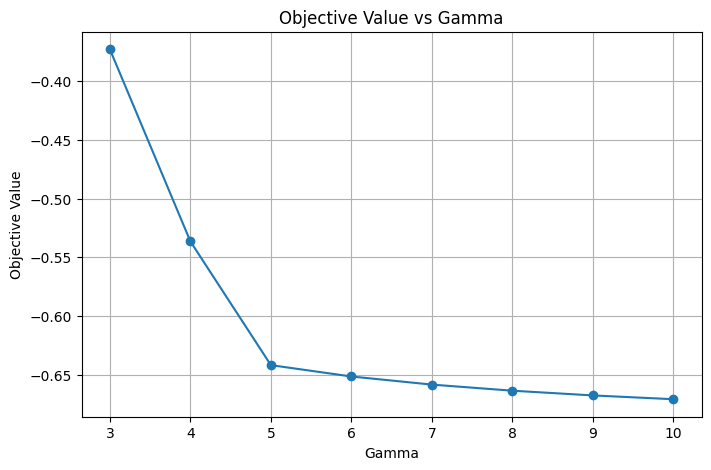

In [ ]:
import matplotlib.pyplot as plt

# Assuming data_observed is already defined and contains a column "w_hat"
sample_policy = np.full((2, len(data_observed)), 0.5)
w_hats = data_observed["w_hat"].values

# Set the range of Gamma values you want to test (from 1 to 10)
Gamma_values = np.arange(1, 11)  # 1,2,...,10

# Lists to store results
solutions = []
objective_values = []

for Gamma in Gamma_values:
    print(f"Solving for Gamma = {Gamma}")
    solution = solve_my_lp(data_observed,
                           sample_policy,
                           hat_w=w_hats,
                           epsilon_0=0.5,
                           epsilon_1=0.5,
                           Gamma=Gamma)
    solutions.append(solution)

    if solution is not None and "objective_value" in solution:
        obj_val = solution["objective_value"]
    else:
        obj_val = np.nan  # Use NaN if no valid solution is returned

    objective_values.append(obj_val)
    print(f"Solution for Gamma {Gamma}: {solution}\n")

# Plotting the objective value vs Gamma
plt.figure(figsize=(8, 5))
plt.plot(Gamma_values, objective_values, marker='o', linestyle='-')
plt.xlabel('Gamma')
plt.ylabel('Objective Value')
plt.title('Objective Value vs Gamma')
plt.grid(True)
plt.show()


**Dual of the Inner Problem**

In [ ]:
def solve_dual_lp(df_observed, policy, hat_w, epsilon_0, epsilon_1, Gamma):
    m = gp.Model("DualLP")
    m.setParam("OutputFlag", 0)  # Suppress solver output


    X_vals = df_observed["X"].values
    T_vals = df_observed["T"].values
    Y_vals = df_observed["Y"].values
    n = len(df_observed)
    I = range(n)


    I0 = [i for i in I if T_vals[i] == 0]
    I1 = [i for i in I if T_vals[i] == 1]
    Tset = [0, 1]


    pi_0_vals = logistic(X_vals)
    pi_1_vals = 1.0 - pi_0_vals

    w_hat = hat_w

    def d(i, j):
        return (X_vals[i] - X_vals[j])**2

    eps = {0: epsilon_0, 1: epsilon_1}

    # Create variables
    beta, gamma, theta, mu, nu = {}, {}, {}, {}, {}

    for t in Tset:
        beta[t] = m.addVar(lb=0.0, name=f"beta_{t}")

    for t in Tset:
        for i_ in I:
            gamma[(t, i_)] = m.addVar(ub = 400, name=f"gamma_{t}_{i_}")
    for t in Tset:
        for i_ in (I0 if t==0 else I1):
            theta[(t, i_)] = m.addVar(lb = -GRB.INFINITY, name=f"theta_{t}_{i_}")

    for i_ in I:
        mu[i_] = m.addVar(lb=0.0, name=f"mu_{i_}")
        nu[i_] = m.addVar(lb=0.0, name=f"nu_{i_}")

    # Objective
    obj_expr = gp.LinExpr()
    for t in Tset:
       obj_expr.addTerms(-eps[t], beta[t])
    for t in Tset:
        for i_ in I:
            obj_expr.addTerms(1.0 / n, gamma[(t, i_)])
    for i_ in I:
        obj_expr.addTerms((1.0 + (1.0 / Gamma)*(w_hat[i_] - 1.0)), mu[i_])
        obj_expr.addTerms(-(1.0 + Gamma*(w_hat[i_] - 1.0)), nu[i_])


    m.setObjective(obj_expr, GRB.MAXIMIZE)

    # Constraints
    for t in Tset:
        for i_ in (I0 if t == 0 else I1):
            lhs = gp.LinExpr()
            lhs += (1.0 / n) * policy[t,i_] * Y_vals[i_]
            lhs.addTerms(1/n, theta[(t, i_)])
            lhs.addTerms(-1.0, mu[i_])
            lhs.addTerms(1.0, nu[i_])
            m.addConstr(lhs >= 0, name=f"cA_t{t}_i{i_}")


    for t in Tset:
        for j_ in (I0 if t == 0 else I1):
            for i_ in I:
                lhs = gp.LinExpr()
                lhs.addTerms(d(i_, j_), beta[t])
                lhs.addTerms(-1.0, gamma[(t, i_)])
                lhs.addTerms(-1.0, theta[(t, j_)])
                m.addConstr(lhs >= 0, name=f"cB_t{t}_i{i_}_j{j_}")


    # Solve
    m.optimize()

    # Retrieve solution
    if m.status == GRB.OPTIMAL:
        print(f"Optimal objective value = {m.objVal:.5f}")
        print("Optimal beta:", {t: beta[t].X for t in Tset})
        print("Optimal gamma:", {(t, i_): gamma[(t, i_)].X for t in Tset for i_ in I})
        print("Optimal theta:", {(t, i_): theta[(t, i_)].X for t in Tset for i_ in (I0 if t==0 else I1)})
        print("Optimal mu:", {i_: mu[i_].X for i_ in I})
        print("Optimal nu:", {i_: nu[i_].X for i_ in I})
        return {
            "objective_value": m.objVal,
            "beta": {t: beta[t].X for t in Tset},
            "gamma": {(t, i_): gamma[(t, i_)].X for t in Tset for i_ in I},
            "theta": {(t, i_): theta[(t, i_)].X for t in Tset for i_ in (I0 if t==0 else I1)},
            "mu": {i_: mu[i_].X for i_ in I},
            "nu": {i_: nu[i_].X for i_ in I}
        }
    else:
        print(f"Model ended with non-OPTIMAL status: {m.status}")
        return None


Solving dual LP for Gamma = 1
Optimal objective value = 185.92952
Optimal beta: {0: 0.0, 1: 0.0}
Optimal gamma: {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (0, 4): 0.0, (0, 5): 0.0, (0, 6): 0.0, (0, 7): 0.0, (0, 8): 0.0, (0, 9): 0.0, (0, 10): 0.0, (0, 11): 0.0, (0, 12): 0.0, (0, 13): 0.0, (0, 14): 0.0, (0, 15): 0.0, (0, 16): 0.0, (0, 17): 0.0, (0, 18): 0.0, (0, 19): 0.0, (1, 0): 400.0, (1, 1): 400.0, (1, 2): 400.0, (1, 3): 400.0, (1, 4): 400.0, (1, 5): 400.0, (1, 6): 400.0, (1, 7): 400.0, (1, 8): 400.0, (1, 9): 400.0, (1, 10): 400.0, (1, 11): 400.0, (1, 12): 400.0, (1, 13): 400.0, (1, 14): 400.0, (1, 15): 400.0, (1, 16): 400.0, (1, 17): 400.0, (1, 18): 400.0, (1, 19): 400.0}
Optimal theta: {(0, 1): 0.0, (0, 2): 0.0, (0, 5): 0.0, (0, 6): 0.0, (0, 7): 0.0, (0, 9): 0.0, (0, 10): 0.0, (0, 11): 0.0, (0, 12): 0.0, (0, 14): 0.0, (0, 16): 0.0, (0, 17): 0.0, (0, 18): 0.0, (0, 19): 0.0, (1, 0): -400.0, (1, 3): -400.0, (1, 4): -400.0, (1, 8): -400.0, (1, 13): -400.0, (1, 15): -400.0}
Opt

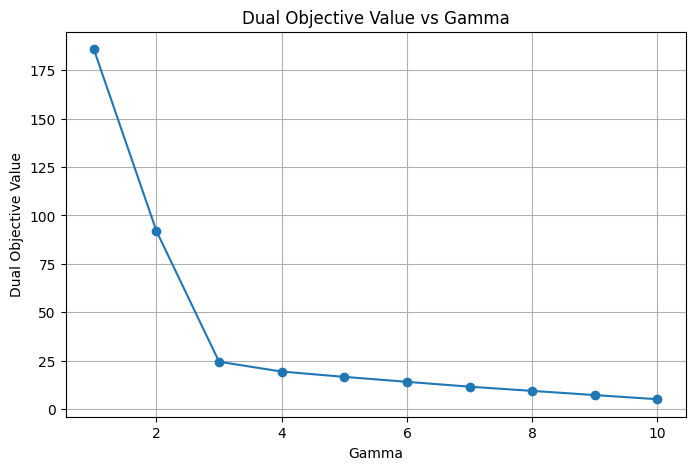

In [ ]:
# Define the range of Gamma values (for example, from 1 to 10)
Gamma_values = np.arange(1, 11)

# List to store the dual objective values for each Gamma
objective_values = []

# Loop over the Gamma values
for Gamma in Gamma_values:
    print(f"Solving dual LP for Gamma = {Gamma}")
    sol = solve_dual_lp(data_observed, sample_policy, w_hat, epsilon_0=0.5, epsilon_1=0.5, Gamma=Gamma)
    if sol is not None:
        obj_val = sol["objective_value"]
    else:
        obj_val = np.NAN # Use NaN if the solution is not optimal
    objective_values.append(obj_val)
    print(f"Gamma = {Gamma}, Objective Value = {obj_val}\n")

# Plot the objective values versus Gamma
plt.figure(figsize=(8, 5))
plt.plot(Gamma_values, objective_values, marker='o', linestyle='-')
plt.xlabel('Gamma')
plt.ylabel('Dual Objective Value')
plt.title('Dual Objective Value vs Gamma')
plt.grid(True)
plt.show()


**Final Problem**

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd

def solve_extended_dual_lp(df_observed,
                           epsilon_0,
                           epsilon_1,
                           Gamma,
                           w_hat):


    m = gp.Model("ExtendedDualLP")

    #data
    X_vals = df_observed["X"].values
    T_vals = df_observed["T"].values
    Y_vals = df_observed["Y"].values
    n = len(df_observed)
    I = range(n)
    I0 = [i for i in I if T_vals[i] == 0]
    I1 = [i for i in I if T_vals[i] == 1]
    Tset = [0, 1]


    #d(x_i, x_j).
    def d(i, j):
        return (X_vals[i] - X_vals[j])**2

    # Epsilon dictionary
    eps = {0: epsilon_0, 1: epsilon_1}

    #Decision Var

    beta, gamma, theta, mu, nu = {}, {}, {}, {}, {}

    for t in Tset:
        beta[t] = m.addVar(lb=0.0, name=f"beta_{t}")

    for t in Tset:
        for i_ in I:
            gamma[(t, i_)] = m.addVar(ub = 400, name=f"gamma_{t}_{i_}")
    for t in Tset:
        for i_ in (I0 if t==0 else I1):
            theta[(t, i_)] = m.addVar(lb = -GRB.INFINITY, name=f"theta_{t}_{i_}")

    for i_ in I:
        mu[i_] = m.addVar(lb=0.0, name=f"mu_{i_}")
        nu[i_] = m.addVar(lb=0.0, name=f"nu_{i_}")

    policy = {}
    for i_ in I:
        for t in Tset:
            policy[(t,i_)] = m.addVar(lb=0.0, name=f"pi_{t}_{i_}")

    m.update()


    #obejctinve function:

    obj_expr = gp.LinExpr()


    # Objective
    obj_expr = gp.LinExpr()
    for t in Tset:
       obj_expr.addTerms(-eps[t], beta[t])
    for t in Tset:
        for i_ in I:
            obj_expr.addTerms(1.0 / n, gamma[(t, i_)])
    for i_ in I:
        obj_expr.addTerms((1.0 + (1.0 / Gamma)*(w_hat[i_] - 1.0)), mu[i_])
        obj_expr.addTerms(-(1.0 + Gamma*(w_hat[i_] - 1.0)), nu[i_])

    m.setObjective(obj_expr, GRB.MAXIMIZE)



    #Constraints


    for t in Tset:
        for i_ in (I0 if t == 0 else I1):
            lhs = gp.LinExpr()
            lhs += (1.0 / n) * policy[t,i_] * Y_vals[i_]
            lhs.addTerms(1/n, theta[(t, i_)])
            lhs.addTerms(-1.0, mu[i_])
            lhs.addTerms(1.0, nu[i_])
            m.addConstr(lhs >= 0, name=f"cA_t{t}_i{i_}")


    for t in Tset:
        for j_ in (I0 if t == 0 else I1):
            for i_ in I:
                lhs = gp.LinExpr()
                lhs.addTerms(d(i_, j_), beta[t])
                lhs.addTerms(-1.0, gamma[(t, i_)])
                lhs.addTerms(-1.0, theta[(t, j_)])
                m.addConstr(lhs >= 0, name=f"cB_t{t}_i{i_}_j{j_}")
    #policy constraint
    for i_ in I:
        lhs = gp.LinExpr()
        for t in Tset:
            lhs.addTerms(1.0, policy[(t,i_)])
        m.addConstr(lhs == 1.0, name=f"C3_piSum_i{i_}")


    #Solve
    m.optimize()

    #Sol
    if m.status == GRB.OPTIMAL:
        print(f"Optimal objective value = {m.objVal:.5f}")

        # Extract variable solutions
        beta_sol  = {t: beta[t].X  for t in Tset}
        gamma_sol = {(t,i_): gamma[(t,i_)].X for t in Tset for i_ in I}
        theta_sol = {(t,i_): theta[(t,i_)].X for t in Tset for i_ in (I0 if t==0 else I1)}
        mu_sol    = {i_: mu[i_].X for i_ in I}
        nu_sol    = {i_: nu[i_].X for i_ in I}
        pi_sol    = {(t,i_): policy[(t,i_)].X for t in Tset for i_ in I}

        return {
            "objective_value": m.objVal,
            "beta":  beta_sol,
            "gamma": gamma_sol,
            "theta": theta_sol,
            "mu": mu_sol,
            "nu": nu_sol,
            "pi": pi_sol
        }
    else:
        print(f"Model ended with status {m.status}, not OPTIMAL.")
        return None

Example:

Solving dual LP for Gamma = 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 440 rows, 142 columns and 1300 nonzeros
Model fingerprint: 0x621a318e
Coefficient statistics:
  Matrix range     [2e-04, 1e+01]
  Objective range  [5e-02, 3e+00]
  Bounds range     [4e+02, 4e+02]
  RHS range        [1e+00, 1e+00]
Presolve removed 40 rows and 80 columns
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 1180 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      63    1.8681933e+02   0.000000e+00   0.000000e+00      0s

Solved in 63 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.868193286e+02
Optimal objective value = 186.81933
Gamma = 1, Objective Value = 186.8193286045992

Sol

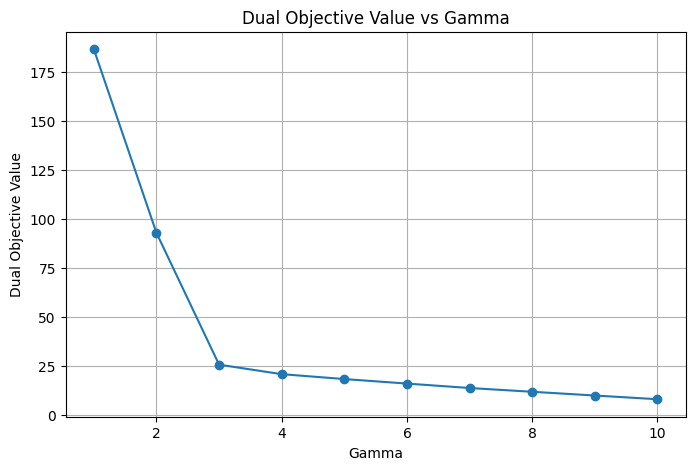

In [ ]:
# Define the range of Gamma values (for example, from 1 to 10)
Gamma_values = np.arange(1, 11)

# List to store the dual objective values for each Gamma
objective_values = []

# Loop over the Gamma values
for Gamma in Gamma_values:
    print(f"Solving dual LP for Gamma = {Gamma}")
    sol = solve_extended_dual_lp(data_observed, epsilon_0=0.5, epsilon_1=0.5, Gamma=Gamma, w_hat=w_hat)
    if sol is not None:
        obj_val = sol["objective_value"]
    else:
        obj_val = np.NAN # Use NaN if the solution is not optimal
    objective_values.append(obj_val)
    print(f"Gamma = {Gamma}, Objective Value = {obj_val}\n")

# Plot the objective values versus Gamma
plt.figure(figsize=(8, 5))
plt.plot(Gamma_values, objective_values, marker='o', linestyle='-')
plt.xlabel('Gamma')
plt.ylabel('Dual Objective Value')
plt.title('Dual Objective Value vs Gamma')
plt.grid(True)
plt.show()